In [1]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


In [2]:
%config IPCompleter.greedy=True
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import numpy as np
import json
import math
import time

In [4]:
data_dir = 'datasets/v1/animals'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# Define normalization transform for reuse
noramlize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     noramlize]),
    'valid': transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     noramlize]),
    'test': transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     noramlize])
    
}

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test':  datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# define the dataloaders using the image datasets and the trainforms,
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32, shuffle=True),
    'test':  torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True)
}

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [7]:
# Load network as feature detector
def build_network(arch="vgg16", out_features=2, hidden_layers=[1000]):
    model = getattr(models, arch)(pretrained=True)

    # Freeze the params from training
    for param in model.parameters():
        param.requires_grad = False

    # Find the number of in features the classifier expects
    try:
        iter(model.classifier)
    except TypeError:
        in_features = model.classifier.in_features
    else:
        in_features = model.classifier[0].in_features
    
    hidden_layers = [in_features] + hidden_layers
    
    # Define how to build a hidden layer
    layer_builder = (
        lambda i, v: (("fc" + str(i)), nn.Linear(hidden_layers[i-1], v)),
        lambda i, v: (("relu" + str(i)), nn.ReLU()),
        lambda i, v: (("drop" + str(i)), nn.Dropout())
    )
    
    # Loop through hidden_layers array and build a layer for each
    layers = [f(i, v) for i, v in enumerate(hidden_layers) if i > 0 for f in layer_builder]
    # Concat the output layer onto the network
    layers += [('fc_final', nn.Linear(hidden_layers[-1], out_features)),
               ('output', nn.LogSoftmax(dim=1))]
    
    classifier = nn.Sequential(OrderedDict(layers))

    # Replace classifier with our classifier
    model.classifier = classifier

    return model

model = build_network()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
def validate(model, criterion, testing_set):
    accuracy = 0
    test_loss = 0
    model.eval() # Evaluation mode
    with torch.no_grad():
        for images, labels in testing_set:
            
            images = images.to(device)
            labels = labels.to(device)

            output = model.forward(images)
            test_loss += criterion(output, labels).item()

            # Take exponential to get log softmax probibilities
            probs = torch.exp(output)

            # highest probability is the predicted class
            # compare with true label
            correct_predictions = (labels.data == probs.max(1)[1])

            # Turn ByteTensor into np_array to calculate mean
            accuracy += np.array(correct_predictions.cpu()).mean()
    
    model.train() # Switch training mode back on
    
    return test_loss/len(testing_set), accuracy/len(testing_set)

def train(model, criterion, optimizer, traning_set, testing_set, epochs=5, log_frequency=20):
    start_time = time.time()
    batch = 0
    train_loss = 0
    for epoch in range(epochs):
        model.train() # Turn on training mode
        
        for images, labels in traning_set:
            batch += 1

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Prevent gradients from accumulating
            
            output = model.forward(images)
            loss = criterion(output, labels) # Calculate loss
            # Back-prop
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            if batch % log_frequency == 0:
                
                test_loss, accuracy = validate(model, criterion, testing_set)
                interval_time = time.time()
                print("Epoch: {} of {}, ".format(epoch+1, epochs),
                      "Train Loss: {:.3f}, ".format(train_loss/log_frequency),
                      "Test Loss: {:.3f}, ".format(test_loss),
                      "Accuracy: %{:.1f}, ".format(accuracy*100),
                      "Time elapsed: {:.1f} seconds".format(interval_time-start_time))
                
                train_loss = 0

In [9]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("training on device:", device)

training on device: cuda:0


In [10]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print("begin training")
train(model, criterion, optimizer, dataloaders['train'], dataloaders['valid'], epochs=1, log_frequency=20)
print("trained")

begin training
Epoch: 1 of 1,  Train Loss: 1.232,  Test Loss: 0.102,  Accuracy: %97.3,  Time elapsed: 24.3 seconds
Epoch: 1 of 1,  Train Loss: 0.287,  Test Loss: 0.074,  Accuracy: %98.0,  Time elapsed: 48.4 seconds
Epoch: 1 of 1,  Train Loss: 0.188,  Test Loss: 0.052,  Accuracy: %98.3,  Time elapsed: 72.7 seconds
Epoch: 1 of 1,  Train Loss: 0.207,  Test Loss: 0.048,  Accuracy: %98.1,  Time elapsed: 97.0 seconds
Epoch: 1 of 1,  Train Loss: 0.156,  Test Loss: 0.043,  Accuracy: %98.3,  Time elapsed: 121.4 seconds
Epoch: 1 of 1,  Train Loss: 0.168,  Test Loss: 0.060,  Accuracy: %97.5,  Time elapsed: 145.9 seconds
Epoch: 1 of 1,  Train Loss: 0.164,  Test Loss: 0.043,  Accuracy: %98.4,  Time elapsed: 170.0 seconds
Epoch: 1 of 1,  Train Loss: 0.139,  Test Loss: 0.046,  Accuracy: %98.3,  Time elapsed: 194.1 seconds
Epoch: 1 of 1,  Train Loss: 0.168,  Test Loss: 0.042,  Accuracy: %98.1,  Time elapsed: 218.3 seconds
Epoch: 1 of 1,  Train Loss: 0.133,  Test Loss: 0.048,  Accuracy: %98.0,  Time el

In [11]:
# Check the test loss and accuracy of the trained network
test_loss, accuracy = validate(model, criterion, dataloaders['test'])
print("Network preformance on test dataset-------------")
print("Accuracy on test dataset: %{:.1f}".format(accuracy*100))

Network preformance on test dataset-------------
Accuracy on test dataset: %98.2


In [12]:
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {
    "arch": "vgg16",
    "class_to_idx": model.class_to_idx,
    'state_dict': model.state_dict(),
    "hidden_layers": [1000]
}

torch.save(checkpoint, "checkpoint.pt")
print("saved checkpoint")

saved checkpoint


In [13]:
def load_model(path):
    checkpoint = torch.load(path)

    arch = checkpoint['arch']
    out_features = len(checkpoint['class_to_idx'])
    hidden_layers = checkpoint['hidden_layers']

    # For loading, use the same build_network function used to make saved model's network
    model = build_network(arch, out_features, hidden_layers)
    model.load_state_dict(checkpoint['state_dict'])

    model.class_to_idx = checkpoint['class_to_idx']
    
    return model
    
loaded_model = load_model('checkpoint.pt')
print("loaded")

loaded


In [14]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Open the image
    pil_image = Image.open(image_path)
    
    # Resize the image
    if pil_image.size[1] < pil_image.size[0]:
        pil_image.thumbnail((255, math.pow(255, 2)))
    else:
        pil_image.thumbnail((math.pow(255, 2), 255))
                            
    # Crop the image
    left = (pil_image.width-224)/2
    bottom = (pil_image.height-224)/2
    right = left + 224
    top = bottom + 224
                            
    pil_image = pil_image.crop((left, bottom, right, top))
                            
    # Turn into np_array
    np_image = np.array(pil_image)/255
    
    # Undo mean and std then transpose
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])  
    np_image = (np_image - mean)/std
    np_image = np.transpose(np_image, (2, 0, 1))
    
    return np_image

In [15]:
def imshow(image, ax=None, title=''):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    plt.show(ax)
    
    return ax

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    if topk < 1:
        topk = 1
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    
    # Turn the np_array image into a FloatTensor
    # before running through model
    tensor_img = torch.FloatTensor([process_image(image_path)])
    # Note: model expects an 1D array of tensors of size (3, 244, 244)
    # so that's why I'm putting the result of process_image()
    # in brackets before passing into FloatTensor()
    # in other words, model expects a tensor of size (1, 3, 244, 244)
    # you coud also use `tensor_img = tensor_img.unsqueeze(0)`
    
    tensor_img = tensor_img.to(device)
    
    result = model(tensor_img).topk(topk)
    
    # Take the natural exponent of each probablility
    # to undo the natural log from the NLLLoss criterion
    probs = torch.exp(result[0].data).cpu().numpy()[0]
    # .cpu() to take the tensor off gpu
    # so it can be turned into a np_array
    # .cpu() should not be called if predicting on a cpu already
    idxs = result[1].data.cpu().numpy()[0]
    
    return(probs, idxs)


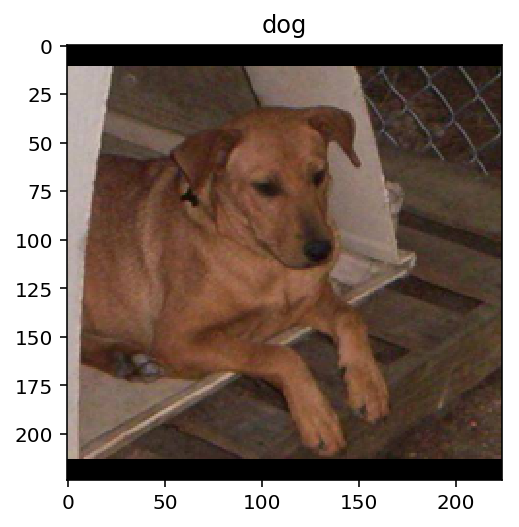

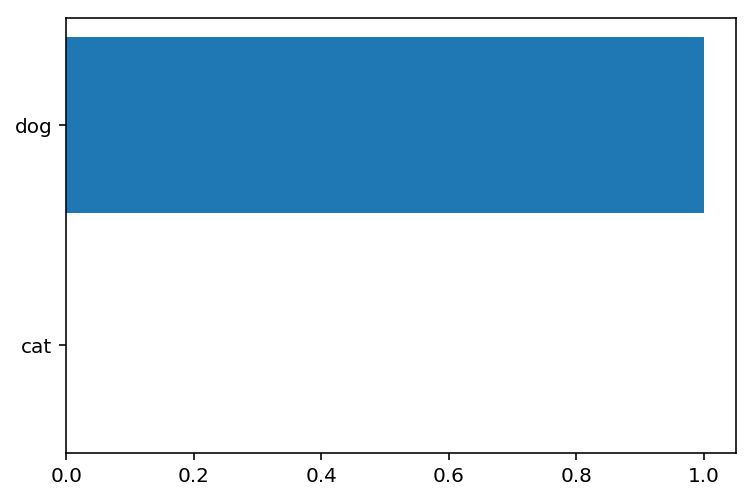

Prediction took 47.689199447631836 milliseconds


In [17]:
test_image_path = test_dir + '/1/dog.100.jpg'
test_image_name = cat_to_name[str(test_image_path.split('/')[-2])]

# Show the image for reference
imshow(process_image(test_image_path), title=test_image_name)

start_time = time.time()
# Get the probabilties and indices from passing the image through the model
probs, idxs = predict(test_image_path, loaded_model, topk=2)
end_time = time.time()


# Swap the keys and values in class_to_idx so that
# indices can be mapped to original classes in dataset
idx_to_class = {v: k for k, v in loaded_model.class_to_idx.items()}

# Map the classes to flower category lables                              
names = list(map(lambda x: cat_to_name[str(idx_to_class[x])], idxs))

# Display top 5 most probable flower categories                               
y_pos = np.arange(len(names))
plt.barh(y_pos, probs)
plt.yticks(y_pos, names)
plt.gca().invert_yaxis()
 
plt.show()
print(f"Prediction took {(end_time-start_time) * 1000} milliseconds")